# Objective 

**Help a daily fantasy sports betting group predict a NBA player's score in Fanduel.**

Fanduel is a sports focused gambling website that offers sportsbook, daily fantasy, and horse race betting. To win in a standard NBA daily fantasy tournament, participants must score in the top 23%. My stakeholders want to increase their chances of winning by using general predictions of NBA player's scores. 
<div>
<center>FanDuel's current scoring table as of 5/6/21 </center><br>

| FGM | FTM | 3PM | REB | AST | STL | BLK | TO | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 2 | 1 | 1 | 1.2 | 1.5 | 3 | 3 | -1 |
</div>    

## Design

**Predict NBA Fanduel player score**

A NBA Fanduel player score is a combination of observation data that measures a player's speciality in a game. To get these specialities, I have to collect data on the player's tendencies and attributes that impact their stats. Equally important are the opponent's defensive tendencies, how good are they at stopping the 3 ball or drive to the basket.

In a NBA game, a team is either on offense or defense. On offense the main contributors are the ball handlers, players with high usage in a coach's offense playbook, the highly efficient scorers with high PER, and 3 point specialists who space out the floor. Defense is measured by points allowed in various sitatuions like on the drive, creating turnovers, and defensive rebounding. Defensive activity could be measured by number of fouls a player has. 

Another key feature is health and energy levels of players. Is the player injured? Did the player come back from injury? Did the player get rest? How active is the player on the offense and defensive end. Is this a revenge game? What are predictors of activity? 

## Data

Nba data from 2017 - 2019, it was around this time when nba transitioned to playing small ball meaning faster pacing and more 3 point shots. This was also before Covid which caused a lot of games to be postponed or canceled. 

# Web Scraping

#### Use Beautiful Soup on Basketball Reference <br>
1. Acquire the list of players who played in Seasons 2017 - 2018 and 2018 - 2019
2. Acquire team info and roster data
3. Gather box scores for players who played in these seasons
  
#### Use Selenium on Nba.com 
1. https://www.nba.com/stats/players/touches/?sort=FRONT_CT_TOUCHES&dir=1
2. https://www.nba.com/stats/players/shooting/?Season=2020-21&SeasonType=Regular%20Season&DistanceRange=By%20Zone
3. https://www.nba.com/stats/players/catch-shoot/
4. https://www.nba.com/stats/teams/opponent-shooting/?Season=2020-21&SeasonType=Regular%20Season&DistanceRange=By%20Zone

In [1]:
from bs4 import BeautifulSoup
import requests
import time, os
import datetime as dt
import re

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

In [3]:
import pandas as pd
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from math import sqrt

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats.mstats import normaltest
from scipy.stats import (boxcox, skew)

In [7]:
from sklearn.linear_model import (LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, PoissonRegressor, lars_path)
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
from sklearn.model_selection import (cross_val_score, cross_val_predict, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures)
from sklearn.pipeline import Pipeline

In [8]:
bball_ref_url = "https://www.basketball-reference.com"
season_avg_link = "/leagues/NBA_{}_per_game.html"
years_list = [2018,2019] #Basketball seasons 2017 - 2018 and 2018 - 2019

In [9]:
def acquire_player_dict(base_url,link,years):
    
    combined_dict = {}
    
    for year in years:
        
        response = requests.get(base_url+link.format(year))
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        tb = soup.find('table', id = "per_game_stats" )
        tr = tb.find_all('tr')
        column_names = [header.text for header in tr[0].find_all('th', scope='col')[1:]] + ['Plyr_Lk', 'Tm_Lk']   
        players_list = []    
        
        for row in tr[1:]:
            player_stats = [stat.text for stat in row.find_all('td')] + [link.find('a').get('href') for link in row.find_all('td') if link.find('a') != None]
            player_dict = dict(zip(column_names,player_stats))
            players_list.append(player_dict)
        
        combined_dict[year] = players_list
        
    return combined_dict

In [10]:
#players_dict = acquire_player_dict(bball_ref_url,season_avg_link,years_list)

In [11]:
def save_raw(player_dict,year):
    
    players_list = player_dict[year]
    df = pd.DataFrame(players_list)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/PlayerLists/'
    return df.to_csv(os.path.join(path,f'players{year}.csv'))

In [12]:
#save_raw(players_dict,2018)
#save_raw(players_dict,2019)

In [13]:
def clean_players(player_dict,year):
    
    players_list = player_dict[year]
    df = pd.DataFrame(players_list)
    
    df.dropna(axis = 0, subset=['PTS'], inplace = True)
    df[['Age', 'G', 'GS']] = df[['Age', 'G', 'GS']].astype(int)
    df.drop(df[df['Tm'] == 'TOT'].index, inplace = True)
    
    filter_df = df.groupby('Player')['G'].sum().reset_index()
    filter_list = list(filter_df[filter_df['G'] > 30]['Player'])
    
    return df[df['Player'].isin(filter_list)]
    
    

In [14]:
#df_2018 = clean_players(players_dict,2018)
#df_2019 = clean_players(players_dict,2019)

In [15]:
def acquire_team_stats(df, base_url, year):
    
    team_name_list = []
    team_info_list = []
    
    for link in df['Tm_Lk'].value_counts().index:
        
        team_name_list.append(link.split('/')[2])
        
        response = requests.get(base_url+link)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        
        columns_list = [strong.text.replace(':','') for strong in soup.find_all('strong')][4:11]
        team_stats_list = [soup.find(text=re.compile(column)).next_element.replace(":","").strip() for column in columns_list]
        team_info_list.append(dict(zip(columns_list,team_stats_list)))
    
    team_df = pd.DataFrame(team_info_list)
    team_df['Team'] = team_name_list
    team_df.set_index('Team', inplace = True)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/TeamStats/'
    
    return team_df.to_csv(os.path.join(path,f'{year}teamstats.csv'))

In [16]:
#acquire_team_stats(df_2018, bball_ref_url, 2018) 
#acquire_team_stats(df_2019, bball_ref_url, 2019)

In [17]:
def ros_column_extract(soup):
    a = []
    b = soup.find('div', id='div_roster').find('th').findNext()
    for i in range(8):
        a.append(b.get('aria-label'))
        b = b.findNext()
    return a

In [18]:
def ros_td_extract(soup):
    d = []
    for row in soup.find('tbody').find_all('tr'):
        td = row.find_all('td')
        row_list = []
        for data in td:
            row_list.append(data.text)
        d.append(row_list)
    return d

In [19]:
def acquire_team_rosters(df, base_url,year):
    
    team_roster_list = []
    
    for link in df['Tm_Lk'].value_counts().index:
        
        #name = []
        #name.append(link.split('/')[2])
        
        response = requests.get(base_url+link)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        columns_list = ros_column_extract(soup)
        team_roster = ros_td_extract(soup)
        team_roster_list += [dict(zip(columns_list, player)) for player in team_roster]
    
    roster_df = pd.DataFrame(team_roster_list)
    #roster_df.set_index('Team', inplace = True)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/TeamStats/'
    
    return roster_df.to_csv(os.path.join(path,f'{year}rosters.csv'))

In [20]:
#acquire_team_rosters(df_2018,bball_ref_url, 2018)
#acquire_team_rosters(df_2019,bball_ref_url, 2019)

In [21]:
def extract_boxscore(soup,name):
    
    player_boxscore = []
    
    for tr in soup.find('table', id='pgl_basic').find('tbody').find_all('tr'):
        row_list = []
        for td in tr.find_all('td'):
            row_list.append(td.text)
        if row_list != []:
            row_list.insert(3,name)
            player_boxscore.append(row_list)
    
    return player_boxscore

In [22]:
def acquire_player_boxscore(df, year):
    
    player_boxscore_list = []
    base_url = "https://www.basketball-reference.com"
    gamelog_url = f'/gamelog/{year}'
    
    for link in df['Plyr_Lk'].value_counts().index:
        
        link = link.split(".")[0]
        
        response = requests.get(base_url+link+gamelog_url)
        page = response.text
        soup = BeautifulSoup(page,"lxml")
        
        name = soup.find('h1').find('span').text.split(" ")[:2][0] + " " + soup.find('h1').find('span').text.split(" ")[:2][1]
        
        columns_list = [header.get('aria-label') for header in soup.find('table', id='pgl_basic').find('tr').find_all('th')][1:]
        columns_list.insert(3, 'Name')
        
        player_boxscore = extract_boxscore(soup,name)
        player_boxscore_list += [dict(zip(columns_list, boxscore)) for boxscore in player_boxscore]
    
    boxscore_df = pd.DataFrame(player_boxscore_list)
    path = r'/home/desbrium/Metis/NBM_Regression_Student/LR_NBAProject/Data/PlayerLists/'
    
    return boxscore_df.to_csv(os.path.join(path,f'{year}box_scores.csv'))

In [23]:
#acquire_player_boxscore(df_2018,2018)
#acquire_player_boxscore(df_2019,2019)

# Cleaning

1. Call in Player, Team, Roster data for a particular year
2. Rename and drop unnecessary features 
3. Change data types to float and int if appropriate
4. Create new columns for features rest days, hot streak, field goal attempts per minute and previous fd score
5. Merge data tables into one dataframe

In [24]:
def create_restday(series):
    new_list = []
    rest_day = 0
    for game in series:
        if game == 0:
            rest_day += 1
            new_list.append(game)
        elif game != 0 and rest_day > 0:
            game = rest_day
            new_list.append(game)
            rest_day = 0
        else:
            new_list.append(0)
    return new_list

In [25]:
def create_hotstreak(series):
    new_list = []
    hot_day = 0
    for streak in series:
        if streak == False:
            new_list.append(0)
            hot_day = 0
        elif streak == True and hot_day == 0:
            new_list.append(1)
            hot_day += 1
        else:
            new_list.append(hot_day)
            hot_day += 1
    return new_list

In [26]:
def change_stats(df):
    for column in df.columns[1:]:
        try:
            df[column] = [float(num.split(" ")[0]) if type(num) != float else num for num in df[column]]
        except:
            continue
    return df 

In [27]:
def clean_features_data(year):
    
    bx_df = pd.read_csv(f'Data/PlayerLists/{year}box_scores.csv')
    rs_df = pd.read_csv(f'Data/TeamStats/{year}rosters.csv')
    tm_df = pd.read_csv(f'Data/TeamStats/{year}teamstats.csv')
    
    rs_df.drop(['Unnamed: 0', 'Birth Date', rs_df.columns[6], 'College'], axis = 1, inplace = True)
    rs_df.rename({'Player': 'Name', 'Years experience in NBA/ABA (prior to this season)': 'Exp'}, axis = 1, inplace = True)
    rs_df['Height'] = rs_df['Height'].apply(lambda x: x.strip().replace("-", "")).apply(lambda x: int(int(x[0])*12 + int(x[1:])))
    rs_df['Exp'] = rs_df['Exp'].replace("R",'0')
    rs_df['Exp'] = rs_df['Exp'].astype(int)
    
    tm_df.drop(['PTS/G', 'SRS', 'Opp PTS/G', 'Net Rtg'], axis = 1, inplace = True)
    tm_df.rename({'Team': 'Opp', 'Pace': 'Opp_Avg_Pace', 'Off Rtg': 'Opp_Avg_Off_Rtg', 'Def Rtg': 'Opp_Avg_Def_Rtg'}, axis = 1, inplace = True)
    tm_df = change_stats(tm_df)
    tm_df['Opp_Avg_Pace'] = tm_df['Opp_Avg_Pace'].fillna(round(tm_df['Opp_Avg_Pace'].mean(),1))
    
    bx_df['Season Game'] = bx_df['Season Game'].fillna(0)
    bx_df['Date'] = pd.to_datetime(bx_df['Date'], format ='%Y-%m-%d')
    bx_df['Year'] = bx_df['Date'].apply(lambda x: x.year)
    bx_df['Month'] = bx_df['Date'].apply(lambda x: x.month)
    bx_df['Games Started'] = bx_df['Games Started'].map({'0':'Bench', '1':'Starter'})
    bx_df['Rest Days'] = create_restday(bx_df['Season Game'])
    
    bx_df.dropna(subset = ['Points'], axis = 0, inplace = True)
    bx_df['FD Score'] = (bx_df['Field Goals'] * 2 + bx_df['Free Throws'] * 1 + bx_df['3-Point Field Goals'] * 1 +
                         bx_df['Total Rebounds'] * 1.2 + bx_df['Assists'] * 1.5 + bx_df['Steals'] * 3 +
                         bx_df['Blocks'] * 3 + bx_df['Turnovers'] * -1)
    
    drop_list = [bx_df.columns[0], bx_df.columns[1], bx_df.columns[6], 
                 bx_df.columns[10], bx_df.columns[-5], bx_df.columns[-4], 
                 bx_df.columns[-3], 'Game Score', 'Points'] + list(bx_df.columns[12:26])
    bx_df.drop(columns= drop_list ,axis = 1, inplace = True)
    
    bx_df.rename({"Player's age on February 1 of the season": 'Age', 'Opponent' : 'Opp'}, axis = 1,  inplace = True)
    bx_df['Age'] = [age[:2] for age in bx_df['Age']]
    bx_df[['Age', 'Personal Fouls', 'Rest Days']] = bx_df[['Age', 'Personal Fouls', 'Rest Days']].astype(int)
    bx_df['Minutes Played'] = round(bx_df['Minutes Played'].apply(lambda x:x.replace(":", ".")).astype(float),2)
    bx_df = bx_df[bx_df['Minutes Played'] > 15.0]
    bx_df['FGA/M'] = bx_df['Field Goal Attempts'] / bx_df['Minutes Played']
    bx_df.dropna(subset = ['FGA/M'], axis = 0, inplace = True)
    bx_df.drop('Field Goal Attempts' ,axis = 1, inplace = True)
    
    mean_df = bx_df.groupby('Name')['FD Score'].mean().round(2).reset_index()
    mean_df.rename({'FD Score' :'Mean FD Score'}, axis = 1, inplace = True)
    bx_df = bx_df.merge(mean_df, 'left', 'Name')
    
    bx_df['FD Diff'] = bx_df['FD Score'] - bx_df['Mean FD Score']
    bx_df['Hot Streak'] = create_hotstreak(bx_df['FD Score'] > bx_df['Mean FD Score'])
    bx_df['Prev FD Score'] = bx_df.groupby('Name')['FD Score'].apply(lambda x:x.shift(1))
    bx_df['Prev FD Score'] = bx_df['Prev FD Score'].fillna(0)
    
    features_df = bx_df.merge(rs_df, how = 'left', on='Name').merge(tm_df, how = 'left', on = 'Opp')
    features_df.drop_duplicates(subset = ['Date', 'Name'], inplace = True)
    
    return features_df

In [28]:
def combine_fill_data(df_list):
    
    df = pd.concat(df_list, axis = 0)
    
    fillna_dict = {'Name': ['Luc Mbah', 'Nenê 2017-18', 'Mo Bamba', 'Nenê 2018-19'], 'Position': ['PF', 'C', 'C', 'C'], 'Height': ['6-8', '6-11', '7-0', '6-11'], 'Weight': [230, 250, 231, 250], 'Exp': [9,15, 0, 16]}
    fillna_df = pd.DataFrame(fillna_dict)
    fillna_df['Height'] = fillna_df['Height'].apply(lambda x: x.replace("-", "")).apply(lambda x: int(int(x[0])*12 + int(x[1:])))
    
    merge_df = df.merge(fillna_df, 'inner', 'Name')
    
    merge_df.drop(['Position_x','Height_x', 'Weight_x', 'Exp_x'], axis = 1, inplace = True)
    merge_df.rename({'Position_y': 'Position', 'Height_y': 'Height', 'Weight_y':'Weight', 'Exp_y': 'Exp'}, axis = 1, inplace = True)
    merge_df = merge_df[['Date', 'Age', 'Name', 'Team', 'Opp', 'Games Started', 'Minutes Played',
                        'Personal Fouls', 'Rest Days', 'FD Score', 'FGA/M', 'Mean FD Score',
                        'FD Diff', 'Hot Streak', 'Prev FD Score', 'Position', 'Height',
                        'Weight', 'Exp', 'Opp_Avg_Pace', 'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg']]
    
    combined_df = pd.concat([df,merge_df], axis = 0)
    combined_df.dropna(subset = ['Height'], axis = 0, inplace = True)
    
    return combined_df

# EDA

In [29]:
nba_list = [clean_features_data(2018), clean_features_data(2019)]

In [30]:
r_fds_df = combine_fill_data(nba_list)
fds_df = combine_fill_data(nba_list)

In [31]:
fds_df.head()

,Date,Age,Name,Team,Opp,Games Started,Minutes Played,Personal Fouls,Rest Days,FD Score,...,FD Diff,Hot Streak,Prev FD Score,Position,Height,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg
0,2017-11-07,27,Sean Kilpatrick,BRK,DEN,Bench,20.28,1,0,16.9,...,-3.07,0,0.0,SG,76.0,210.0,3.0,96.8,112.5,111.0
4,2017-11-26,27,Sean Kilpatrick,BRK,MEM,Bench,20.44,2,0,12.0,...,-7.97,0,16.9,SG,76.0,210.0,3.0,94.9,104.5,111.0
8,2017-11-27,27,Sean Kilpatrick,BRK,HOU,Bench,28.08,2,0,21.2,...,1.23,1,12.0,SG,76.0,210.0,3.0,97.6,114.7,106.1
12,2017-11-29,27,Sean Kilpatrick,BRK,DAL,Bench,17.03,2,0,7.6,...,-12.37,0,21.2,SG,76.0,210.0,3.0,95.6,106.3,109.5
16,2017-12-02,27,Sean Kilpatrick,BRK,ATL,Bench,15.23,1,0,17.6,...,-2.37,0,7.6,SG,76.0,210.0,3.0,98.3,105.0,110.6


In [32]:
fds_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38529 entries, 0 to 118
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             38529 non-null  datetime64[ns]
 1   Age              38529 non-null  int64         
 2   Name             38529 non-null  object        
 3   Team             38529 non-null  object        
 4   Opp              38529 non-null  object        
 5   Games Started    38529 non-null  object        
 6   Minutes Played   38529 non-null  float64       
 7   Personal Fouls   38529 non-null  int64         
 8   Rest Days        38529 non-null  int64         
 9   FD Score         38529 non-null  float64       
 10  FGA/M            38529 non-null  float64       
 11  Mean FD Score    38529 non-null  float64       
 12  FD Diff          38529 non-null  float64       
 13  Hot Streak       38529 non-null  int64         
 14  Prev FD Score    38529 non-null  float64

In [33]:
fds_df.dtypes

Date               datetime64[ns]
Age                         int64
Name                       object
Team                       object
Opp                        object
Games Started              object
Minutes Played            float64
Personal Fouls              int64
Rest Days                   int64
FD Score                  float64
FGA/M                     float64
Mean FD Score             float64
FD Diff                   float64
Hot Streak                  int64
Prev FD Score             float64
Position                   object
Height                    float64
Weight                    float64
Exp                       float64
Opp_Avg_Pace              float64
Opp_Avg_Off_Rtg           float64
Opp_Avg_Def_Rtg           float64
dtype: object

In [34]:
fds_df.describe() 

,Age,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,Mean FD Score,FD Diff,Hot Streak,Prev FD Score,Height,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg
count,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000,38529.000000
mean,26.422669,27.112695,2.205975,0.156505,25.631607,0.364195,25.631546,0.000062,0.717226,25.157676,78.493706,219.789743,5.161904,98.741958,109.494716,109.523735
std,4.149122,6.958863,1.430522,1.224091,12.935235,0.143463,8.935143,9.353246,1.123848,13.297343,3.374203,25.135231,4.065928,2.312165,3.175839,2.833261
min,19.000000,15.010000,0.000000,0.000000,-1.000000,0.000000,8.050000,-40.510000,0.000000,-1.000000,69.000000,160.000000,0.000000,94.900000,103.500000,103.900000
25%,23.000000,21.340000,1.000000,0.000000,16.100000,0.261438,19.140000,-6.300000,0.000000,15.700000,76.000000,200.000000,2.000000,96.800000,107.100000,107.600000
50%,26.000000,27.110000,2.000000,0.000000,23.700000,0.354862,23.810000,-0.620000,0.000000,23.400000,78.000000,220.000000,4.000000,98.400000,109.500000,109.700000
75%,29.000000,32.470000,3.000000,0.000000,33.100000,0.456969,30.020000,5.700000,1.000000,32.900000,81.000000,240.000000,8.000000,100.300000,112.200000,111.100000
max,42.000000,55.500000,6.000000,47.000000,98.500000,1.134122,58.710000,50.240000,16.000000,98.500000,88.000000,290.000000,20.000000,103.900000,115.900000,117.600000


In [35]:
r_fds_df = fds_df.copy()

In [36]:
fds_df = pd.get_dummies(fds_df,columns=['Games Started', 'Position'],drop_first=True)

In [37]:
fds_df_f = fds_df[['Age', 'Minutes Played', 'Personal Fouls', 'Rest Days', 'FGA/M', 
                   'Hot Streak', 'Prev FD Score', 'Weight', 'Exp', 'Opp_Avg_Pace', 
                   'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg', 'Games Started_Starter', 
                   'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']]

In [38]:
fds_df_t = fds_df['FD Score']

In [39]:
fds_df.corr()

,Age,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,Mean FD Score,FD Diff,Hot Streak,Prev FD Score,...,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
Age,1.000000,-0.029929,-0.071376,0.009594,-0.026970,-0.030770,-0.041710,2.546610e-03,-0.012858,-0.022775,...,1.127463e-02,0.904617,-0.018111,-0.015380,-0.003171,-0.020016,0.043528,0.002317,-0.053536,0.005987
Minutes Played,-0.029929,1.000000,0.172700,-0.054670,0.659518,0.237146,0.521381,4.140185e-01,0.279139,0.418256,...,-2.526010e-02,0.040583,0.002473,0.014818,-0.010527,0.562105,-0.011502,0.009323,0.053056,0.051778
Personal Fouls,-0.071376,0.172700,1.000000,-0.000415,0.143195,0.007151,0.130855,7.302843e-02,0.058154,0.101840,...,1.455483e-01,-0.062170,0.044186,0.034521,0.001247,0.137318,0.026150,-0.063474,-0.014577,-0.076496
Rest Days,0.009594,-0.054670,-0.000415,1.000000,-0.022511,0.008079,-0.005398,-2.597492e-02,-0.022676,-0.070773,...,2.231148e-03,0.008389,0.005035,-0.000688,0.011880,-0.038573,-0.002703,0.011118,-0.003433,-0.006589
FD Score,-0.026970,0.659518,0.143195,-0.022511,1.000000,0.517666,0.690761,7.230841e-01,0.408452,0.495245,...,1.490763e-01,0.075030,0.057151,-0.008275,0.057125,0.394249,-0.018888,0.043022,-0.064438,-0.088659
FGA/M,-0.030770,0.237146,0.007151,0.008079,0.517666,1.000000,0.457090,2.792576e-01,0.166264,0.315194,...,-4.820998e-02,0.061589,0.072374,0.024512,0.023515,0.147122,-0.035811,0.074417,-0.067360,0.086361
Mean FD Score,-0.041710,0.521381,0.130855,-0.005398,0.690761,0.457090,1.000000,1.855446e-06,0.024577,0.669837,...,2.158143e-01,0.108622,0.031053,0.019997,0.015850,0.482022,-0.027350,0.062257,-0.093266,-0.128340
FD Diff,0.002547,0.414018,0.073028,-0.025975,0.723084,0.279258,0.000002,1.000000e+00,0.541398,0.045013,...,6.580435e-07,-0.000002,0.049374,-0.030548,0.063861,0.084759,0.000006,0.000025,-0.000018,-0.000009
Hot Streak,-0.012858,0.279139,0.058154,-0.022676,0.408452,0.166264,0.024577,5.413977e-01,1.000000,0.165823,...,2.100663e-03,-0.005686,0.021288,-0.019079,0.034555,0.092529,-0.001386,0.010118,0.001601,-0.008370
Prev FD Score,-0.022775,0.418256,0.101840,-0.070773,0.495245,0.315194,0.669837,4.501345e-02,0.165823,1.000000,...,1.427582e-01,0.075428,0.016617,0.010897,0.008776,0.378282,-0.017373,0.040705,-0.061184,-0.083978


<AxesSubplot:xlabel='Opp_Avg_Def_Rtg', ylabel='FD Score'>

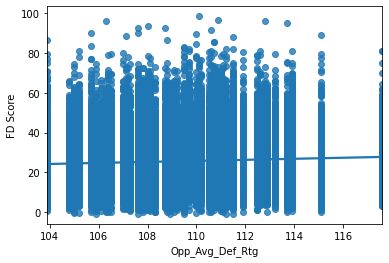

In [40]:
sns.regplot(x="Opp_Avg_Def_Rtg", y="FD Score", data=fds_df) #no strong linear correlation

<AxesSubplot:xlabel='Opp_Avg_Def_Rtg', ylabel='FD Score'>

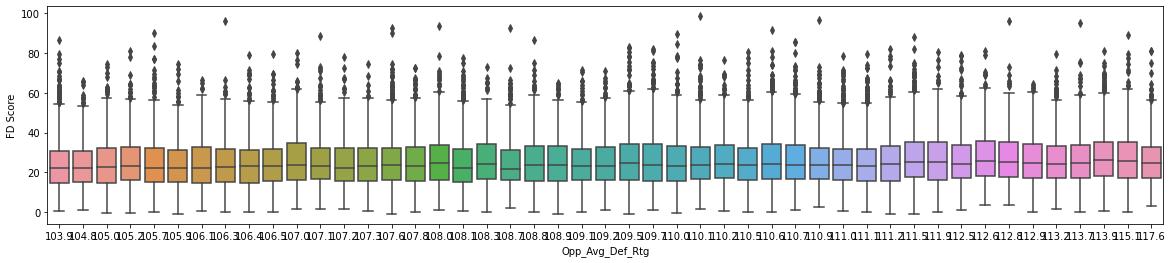

In [41]:
plt.figure(figsize=(20,4))
sns.boxplot(x="Opp_Avg_Def_Rtg", y="FD Score", data= fds_df)

<AxesSubplot:xlabel='Exp', ylabel='FD Score'>

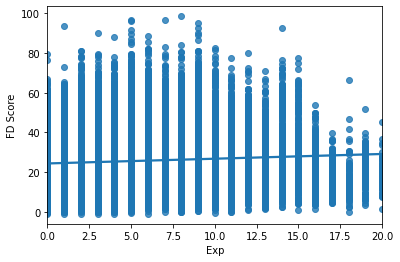

In [42]:
sns.regplot(x="Exp", y="FD Score", data=fds_df) # Some correlation

<AxesSubplot:xlabel='Exp', ylabel='FD Score'>

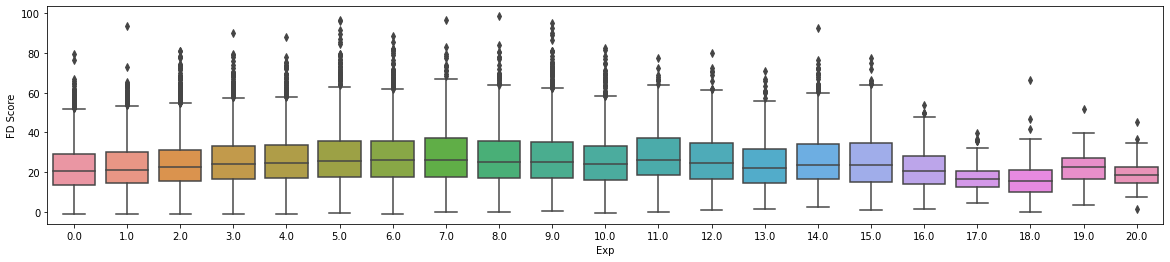

In [43]:
plt.figure(figsize=(20,4))
sns.boxplot(x="Exp", y="FD Score", data= fds_df)

<AxesSubplot:xlabel='FGA/M', ylabel='FD Score'>

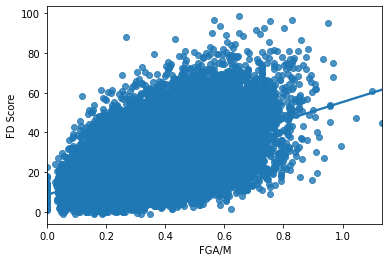

In [44]:
sns.regplot(x="FGA/M", y="FD Score", data=fds_df) # Looks like a strong linear correlation

<AxesSubplot:xlabel='Minutes Played', ylabel='FD Score'>

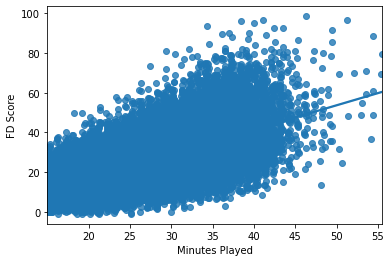

In [45]:
sns.regplot(x="Minutes Played", y="FD Score", data=fds_df) # Looks like a strong linear correlation

Text(0, 0.5, 'FD Score')

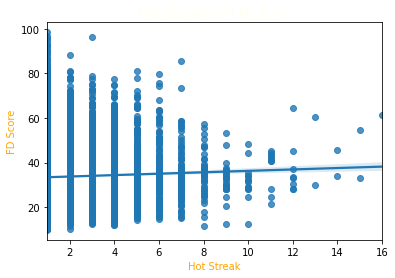

In [46]:
plt.title('Hot Streaks and FD Score', color = '#FFFFF0')
sns.regplot(x="Hot Streak", y="FD Score", data=fds_df[fds_df['Hot Streak'] != 0]) 
plt.xlabel('Hot Streak', color = '#FFA500')
plt.ylabel('FD Score', color = '#FFA500')

<AxesSubplot:xlabel='Prev FD Score', ylabel='FD Score'>

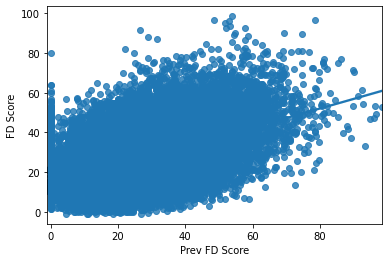

In [47]:
sns.regplot(x="Prev FD Score", y="FD Score", data=fds_df)

<AxesSubplot:xlabel='Weight', ylabel='FD Score'>

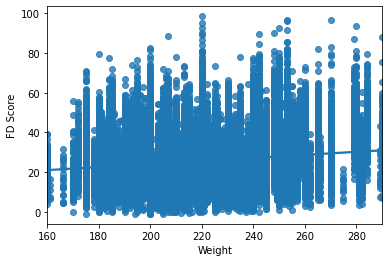

In [48]:
sns.regplot(x="Weight", y="FD Score", data=fds_df) # Looks like a categorical variable to me

<AxesSubplot:xlabel='Weight', ylabel='FD Score'>

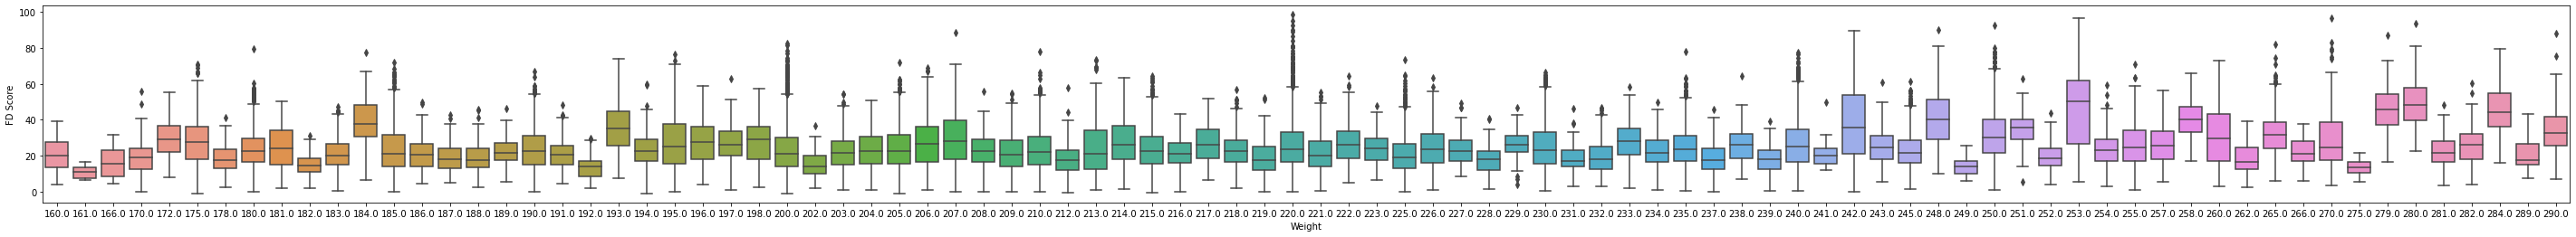

In [49]:
plt.figure(figsize=(50,4))
sns.boxplot(x="Weight", y="FD Score", data= fds_df) #Potentially strong indicator of fdscore?

Text(0, 0.5, 'FD Score')

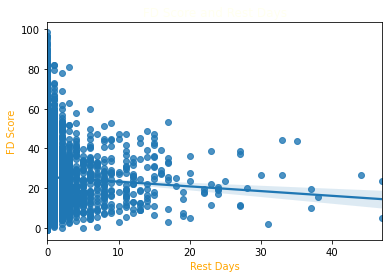

In [50]:
plt.title('FD Score and Rest Days', color = '#FFFFF0')
sns.regplot(x="Rest Days", y="FD Score", data=fds_df) # The number of rest days also indicate injuries, we don't expect injured players to perform as well as healthy players with less than 10 games missing
plt.xlabel('Rest Days', color = '#FFA500')
plt.ylabel('FD Score', color = '#FFA500')

<AxesSubplot:xlabel='Personal Fouls', ylabel='FD Score'>

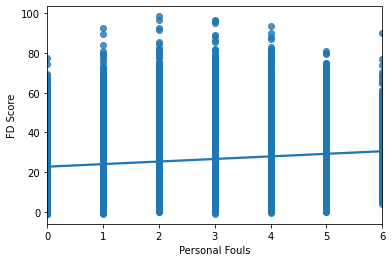

In [51]:
sns.regplot(x="Personal Fouls", y="FD Score", data=fds_df)

<AxesSubplot:xlabel='Personal Fouls', ylabel='FD Score'>

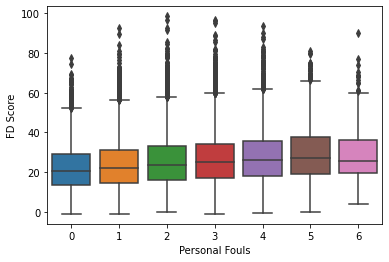

In [52]:
sns.boxplot(x="Personal Fouls", y="FD Score", data= fds_df) #Shows the defensive activity of players. There is a decrease in fd score for players with 3-5 fouls and after 6 they get kicked out of the game

<AxesSubplot:xlabel='Team', ylabel='FD Score'>

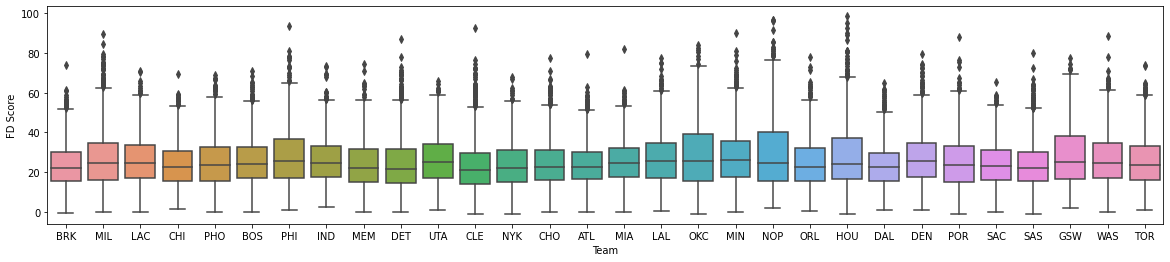

In [53]:
plt.figure(figsize=(20,4))
sns.boxplot(x="Team", y="FD Score", data= fds_df)# no strong correlation

<AxesSubplot:xlabel='Opp', ylabel='FD Score'>

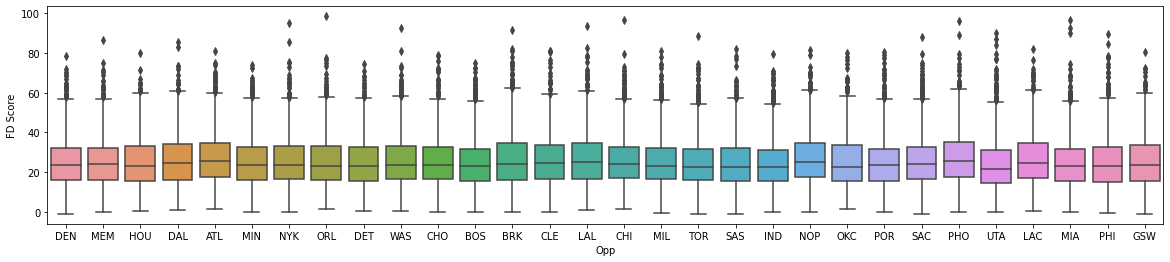

In [54]:
plt.figure(figsize=(20,4))
sns.boxplot(x="Opp", y="FD Score", data= fds_df)

<AxesSubplot:xlabel='Position', ylabel='FD Score'>

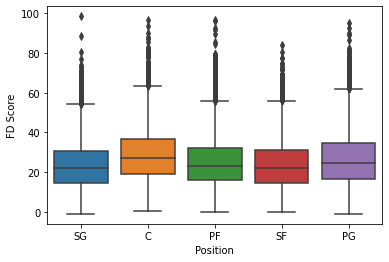

In [55]:
sns.boxplot(x="Position", y="FD Score", data = r_fds_df)

<AxesSubplot:xlabel='Games Started', ylabel='FD Score'>

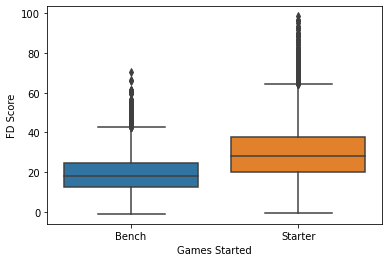

In [56]:
sns.boxplot(x="Games Started", y="FD Score", data= r_fds_df) #hue scatter

# Baselining

In [57]:
def base_linear_regress_model(features,target):
    
    lrmodel = Pipeline([("lm",  LinearRegression())])
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    lrmodel.fit(X_train,y_train)
    
    y_train_pred = lrmodel.predict(X_train)
    print(f'Training R^2 Score: {lrmodel.score(X_train, y_train)}')
    print(f'Training RMSE: {sqrt(mean_squared_error(y_train_pred, y_train))}')
    print(f'Training MAE: {mean_absolute_error(y_train_pred, y_train)}')
    
    y_test_pred = lrmodel.predict(X_test)
    print(f'Test R^2 Score: {lrmodel.score(X_test, y_test)}')
    print(f'Test RMSE: {sqrt(mean_squared_error(y_train_pred, y_train))}')
    print(f'Test MAE: {mean_absolute_error(y_test_pred, y_test)}')
    
    lrmodel2 = Pipeline([("lm",  LinearRegression())])
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    X, X_test2, y, y_test2 = train_test_split(features, target, test_size=0.2, random_state=42)
    X_train2, X_val, y_train2, y_val = train_test_split(features, target, test_size=0.2, random_state=42)
    
    scores = cross_val_score(lrmodel2, X_train2, y_train2, cv=kfold)
    
    print(f'Cross validation scores : {scores}')
    print(f'Cross validation scores : {np.mean(scores)}')
    
    lrmodel2.fit(X_train2,y_train2)
    
    '''The below code gives the same print result as the code above'''
    
    #y_train_pred2 = lrmodel.predict(X_train)
    #print(f'Training R^2 Score: {lrmodel.score(X_train2, y_train2)}')
    #print(f'Training RMSE: {sqrt(mean_squared_error(y_train_pred2, y_train2))}')
    #print(f'Training MAE: {mean_absolute_error(y_train_pred2, y_train2)}')
    
    #y_val_pred2 = lrmodel.predict(X_val)
    #print(f'Validation R^2 Score: {lrmodel.score(X_val, y_val)}')
    #print(f'Validation RMSE: {sqrt(mean_squared_error(y_val_pred2, y_val))}')
    #print(f'Validation MAE: {mean_absolute_error(y_val_pred2, y_val)}')
    
    #y_test_pred2 = lrmodel.predict(X_test2)
    #print(f'Test R^2 Score: {lrmodel.score(X_test2, y_test2)}')
    #print(f'Test RMSE: {sqrt(mean_squared_error(y_test_pred2, y_test2))}')
    #print(f'Test MAE: {mean_absolute_error(y_test_pred2, y_test2)}')
    
    return (X_train2, X_val, X_test2, y_train2, y_val, y_test2)

In [58]:
X_train2, X_val, X_test2, y_train2, y_val, y_test2 = base_linear_regress_model(fds_df_f, fds_df_t)

Training R^2 Score: 0.6850205173145631
Training RMSE: 7.256913673779181
Training MAE: 5.590420023489153
Test R^2 Score: 0.6844943075416979
Test RMSE: 7.256913673779181
Test MAE: 5.614603579545828
Cross validation scores : [0.68404225 0.68644522 0.67033296 0.68906962 0.69267176]
Cross validation scores : 0.6845123609680444


In [59]:
def create_preds(x_train, y_train, x_test):
    
    lrmodel = Pipeline([("lm",  LinearRegression())])
    
    lrmodel.fit(x_train, y_train)
    
    y_train_pred = lrmodel.predict(X_train2)
    y_test_pred = lrmodel.predict(X_test2)
    
    return (y_train_pred, y_test_pred)

In [60]:
y_train_pred, y_test_pred = create_preds(X_train2, y_train2, X_test2)

In [61]:
#fig, axes = plt.subplots(1, 3, figsize=(15, 5))

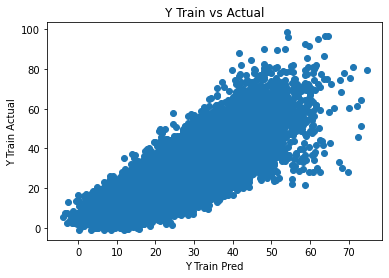

In [62]:
ax = plt.axes()

ax.scatter(y_train_pred, y_train2)

ax.set(xlabel='Y Train Pred',
       ylabel='Y Train Actual',
       title='Y Train vs Actual');

In [63]:
print(f'MAE : {mean_absolute_error(y_train_pred, y_train2)}')
print(f'RMSE : {sqrt(mean_squared_error(y_train_pred, y_train2))}')

MAE : 5.590420023489153
RMSE : 7.256913673779181


Text(0, 0.5, 'Y Test Actual')

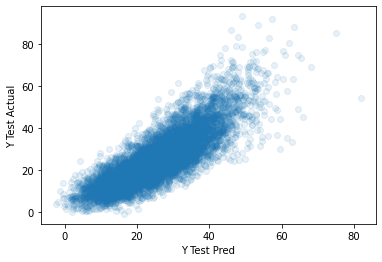

In [64]:
plt.scatter(y_test_pred, y_test2, alpha = 0.1)
plt.xlabel('Y Test Pred')
plt.ylabel('Y Test Actual')

In [65]:
print(f'MAE : {mean_absolute_error(y_test_pred, y_test2)}')
print(f'RMSE : {sqrt(mean_squared_error(y_test_pred, y_test2))}')

MAE : 5.614603579545828
RMSE : 7.2757473144017615


In [66]:
model = sm.OLS(fds_df_t, sm.add_constant(fds_df_f))
fit = model.fit()
fit.summary() # check error metrics # interesting corr: minutes played, position 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FD Score   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     4925.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        09:25:32   Log-Likelihood:            -1.3105e+05
No. Observations:               38529   AIC:                         2.621e+05
Df Residuals:                   38511   BIC:                         2.623e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -45.8737      2.472    -18.555      0.000     -50.720     -41.028
Age                      -0.1972      0.022     -9.007      0.000      -0.240      -0.154
Minutes Played            0.9488      0.007    132.484      0.000       0.935       0.963
Personal Fouls            0.0121      0.027      0.451      0.652      -0.040       0.065
Rest Days                 0.1194      0.030      3.933      0.000       0.060       0.179
FGA/M                    30.3914      0.284    107.187      0.000      29.836      30.947
Hot Streak                2.1968      0.035     63.166      0.000       2.129       2.265
Prev FD Score             0.1036      0.003     31.087      0.000       0.097       0.110
Weight                    0.0567      0.003     20.695      0.000       0.051       0.062
Exp                       0.2267      0.022     10.087      0.000       0.183       0.271
Opp_Avg_Pace              0.1397      0.017      8.108      0.000       0.106       0.174
Opp_Avg_Off_Rtg          -0.0717      0.012     -5.750      0.000      -0.096      -0.047
Opp_Avg_Def_Rtg           0.1804      0.014     13.050      0.000       0.153       0.208
Games Started_Starter    -0.6437      0.095     -6.781      0.000      -0.830      -0.458
Position_PF              -4.0641      0.131    -31.131      0.000      -4.320      -3.808
Position_PG              -1.6127      0.201     -8.009      0.000      -2.007      -1.218
Position_SF              -4.9692      0.158    -31.455      0.000      -5.279      -4.660
Position_SG              -5.5261      0.173    -31.881      0.000      -5.866      -5.186
==============================================================================
Omnibus:                     2032.053   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3674.262
Skew:                           0.411   Prob(JB):                         0.00
Kurtosis:                       4.270   Cond. No.                     1.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

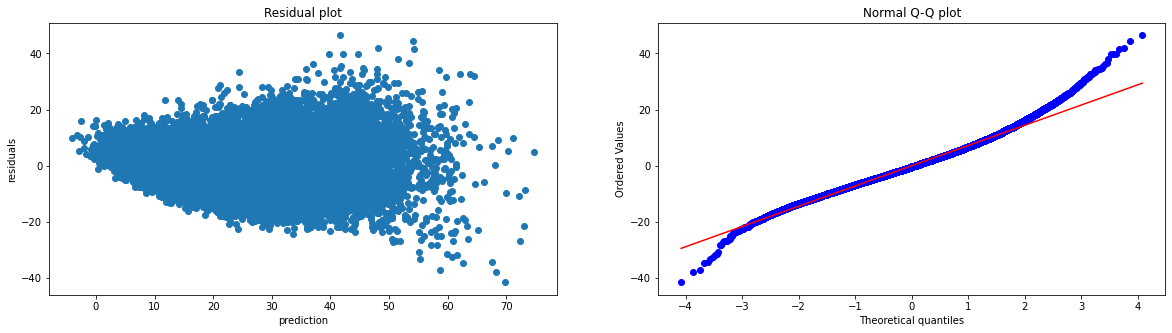

In [68]:
diagnostic_plot(X_train2, y_train2) #the residual's variance is not constant and qq plot shows deviations

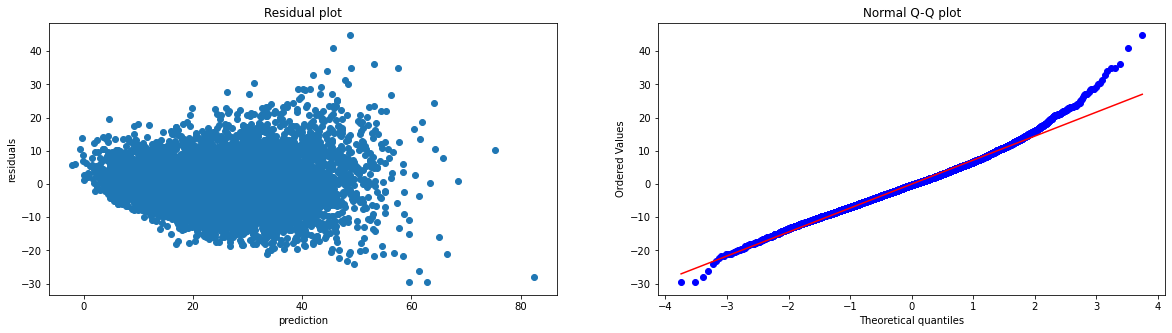

In [69]:
diagnostic_plot(X_test2, y_test2)

# Transformation

In [70]:
def check_skew(df):
    skew_dict = {}
    for column in df.columns:
        if df[column].dtypes == np.float:
            skew_dict[column] = [f'skew {skew(df[column])}', f'norm {normaltest(df[column])}']
    return skew_dict

In [71]:
check_skew(fds_df_f)

{'Minutes Played': ['skew 0.15061572254302724',
  'norm NormaltestResult(statistic=3542.957322463278, pvalue=0.0)'],
 'FGA/M': ['skew 0.3589146081661381',
  'norm NormaltestResult(statistic=783.1866325189261, pvalue=8.574002352216743e-171)'],
 'Prev FD Score': ['skew 0.7368769564993828',
  'norm NormaltestResult(statistic=3378.74188655846, pvalue=0.0)'],
 'Weight': ['skew 0.22958932480162236',
  'norm NormaltestResult(statistic=670.8865828295177, pvalue=2.0836729178641053e-146)'],
 'Exp': ['skew 0.8137123853027441',
  'norm NormaltestResult(statistic=3372.1869154041665, pvalue=0.0)'],
 'Opp_Avg_Pace': ['skew 0.38515422184146214',
  'norm NormaltestResult(statistic=2048.3632308281103, pvalue=0.0)'],
 'Opp_Avg_Off_Rtg': ['skew -0.01595438532104047',
  'norm NormaltestResult(statistic=3697.939175625334, pvalue=0.0)'],
 'Opp_Avg_Def_Rtg': ['skew 0.1944501148348359',
  'norm NormaltestResult(statistic=241.91076642839445, pvalue=2.949473602170394e-53)']}

[Text(0.5, 0, 'FGA Per Minute'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Distribution of FGA/M')]

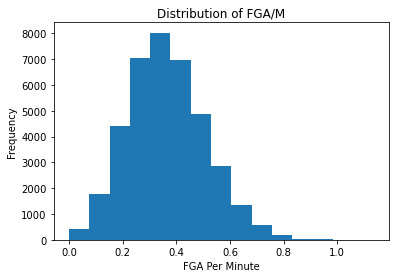

In [72]:
ax = plt.axes()
ax.hist(fds_df_f['FGA/M'], bins=15);

ax.set(xlabel='FGA Per Minute', 
       ylabel='Frequency',
       title='Distribution of FGA/M')

There is a slight skew for FGA/M, I should perform a log transformation.

<AxesSubplot:>

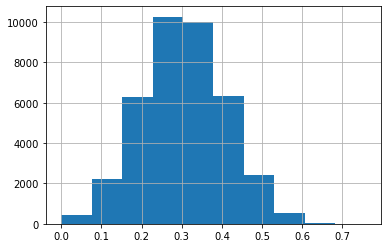

In [73]:
fds_df_f['FGA/M'].apply(np.log1p).hist()

In [74]:
fds_df_f['FGA/M'] = fds_df_f['FGA/M'].apply(np.log1p)

<ipython-input-74-3ae997e6c9f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fds_df_f['FGA/M'] = fds_df_f['FGA/M'].apply(np.log1p)


In [75]:
fds_df_f["Minutes Played"] = fds_df_f["Minutes Played"] ** 2

<ipython-input-75-d7078709961e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fds_df_f["Minutes Played"] = fds_df_f["Minutes Played"] ** 2


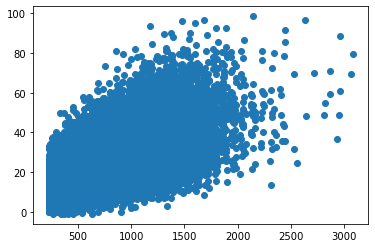

In [76]:
plt.scatter(fds_df_f["Minutes Played"], fds_df_t)

(array([1.1967e+04, 9.3400e+03, 7.9510e+03, 5.8900e+03, 2.7190e+03,
        5.1900e+02, 9.5000e+01, 3.2000e+01, 6.0000e+00, 1.0000e+01]),
 array([ 225.3001 ,  510.79509,  796.29008, 1081.78507, 1367.28006,
        1652.77505, 1938.27004, 2223.76503, 2509.26002, 2794.75501,
        3080.25   ]),
 <BarContainer object of 10 artists>)

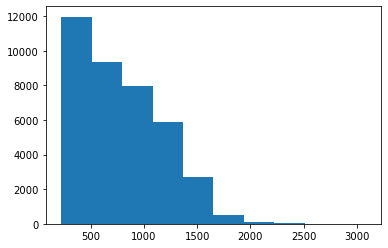

In [77]:
plt.hist(fds_df_f["Minutes Played"])

(array([2860., 3957., 4101., 5458., 6028., 6854., 6786., 2232.,  227.,
          26.]),
 array([5.41743329, 5.67896657, 5.94049984, 6.20203312, 6.46356639,
        6.72509967, 6.98663294, 7.24816622, 7.50969949, 7.77123277,
        8.03276604]),
 <BarContainer object of 10 artists>)

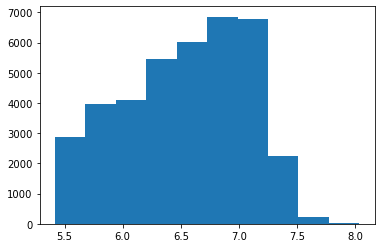

In [78]:
plt.hist(np.log(fds_df_f["Minutes Played"]))

In [79]:
fds_df_f["Minutes Played"] = np.log(fds_df_f["Minutes Played"])

<ipython-input-79-238daa3ecb22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fds_df_f["Minutes Played"] = np.log(fds_df_f["Minutes Played"])


In [80]:
X_train2, X_val, X_test2, y_train2, y_val, y_test2 = base_linear_regress_model(fds_df_f, fds_df_t)

Training R^2 Score: 0.6734051309738665
Training RMSE: 7.38950764709445
Training MAE: 5.695167741201659
Test R^2 Score: 0.6701185082724391
Test RMSE: 7.38950764709445
Test MAE: 5.7497485259035335
Cross validation scores : [0.6726075  0.67386    0.65826166 0.67730871 0.68236038]
Cross validation scores : 0.6728796475905044


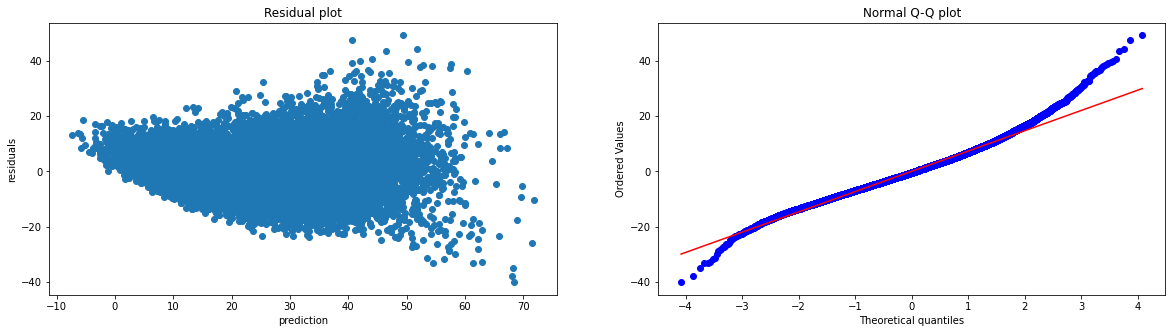

In [81]:
diagnostic_plot(X_train2, y_train2)

# Regularization

In [82]:
std = StandardScaler()
std.fit(fds_df_f)
X_tr = std.transform(X_train2)
X_te = std.transform(X_val)

In [83]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train2)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [84]:
lasso_model.alpha_

0.01

In [85]:
test_set_pred = lasso_model.predict(X_te)

In [86]:
mean_absolute_error(y_val, test_set_pred)

5.748173332306081

In [87]:
list(zip(X_train2.columns, lasso_model.coef_))

[('Age', -0.8262291024122268),
 ('Minutes Played', 6.33410638297366),
 ('Personal Fouls', 0.08915314006661017),
 ('Rest Days', 0.16434251179118403),
 ('FGA/M', 4.336854424268574),
 ('Hot Streak', 2.505933529279013),
 ('Prev FD Score', 1.4791696957486054),
 ('Weight', 1.5040678531385032),
 ('Exp', 0.944734894935582),
 ('Opp_Avg_Pace', 0.3139745548330533),
 ('Opp_Avg_Off_Rtg', -0.20321449417604373),
 ('Opp_Avg_Def_Rtg', 0.5093795251471079),
 ('Games Started_Starter', -0.2474043972639219),
 ('Position_PF', -1.5217476752451673),
 ('Position_PG', -0.5084807427170621),
 ('Position_SF', -1.726242266133699),
 ('Position_SG', -2.2390596886549643)]

None of the coefficients were zeroed out and the alpha is low. I don't need regularization for my model.

# Polynomial 

In [88]:
pf = PolynomialFeatures(degree=2)
pf.fit(fds_df_f)
feat_array = pf.transform(fds_df_f)
fds_df_f_2 = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features= fds_df_f.columns))

In [89]:
X_train2, X_val, X_test2, y_train2, y_val, y_test2 = base_linear_regress_model(fds_df_f_2, fds_df_t)

Training R^2 Score: 0.751815672294646
Training RMSE: 6.441663002232507
Training MAE: 4.909333544347451
Test R^2 Score: 0.7436806607768427
Test RMSE: 6.441663002232507
Test MAE: 5.031599774824723
Cross validation scores : [0.74790621 0.74734498 0.74166187 0.74022639 0.75743132]
Cross validation scores : 0.7469141550672334


In [90]:
y_train_pred, y_test_pred = create_preds(X_train2, y_train2, X_test2)

Text(0, 0.5, 'Y Test Actual')

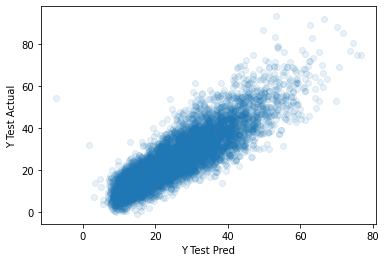

In [91]:
plt.scatter(y_test_pred, y_test2, alpha = 0.1)
plt.xlabel('Y Test Pred')
plt.ylabel('Y Test Actual')

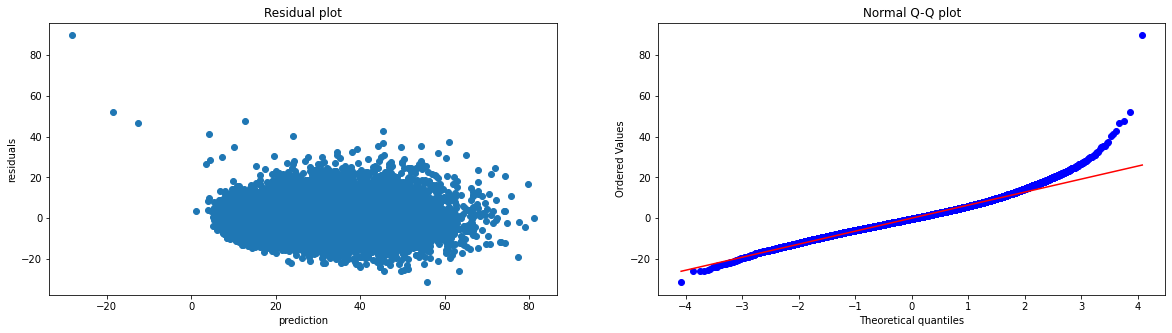

In [92]:
diagnostic_plot(X_train2, y_train2)

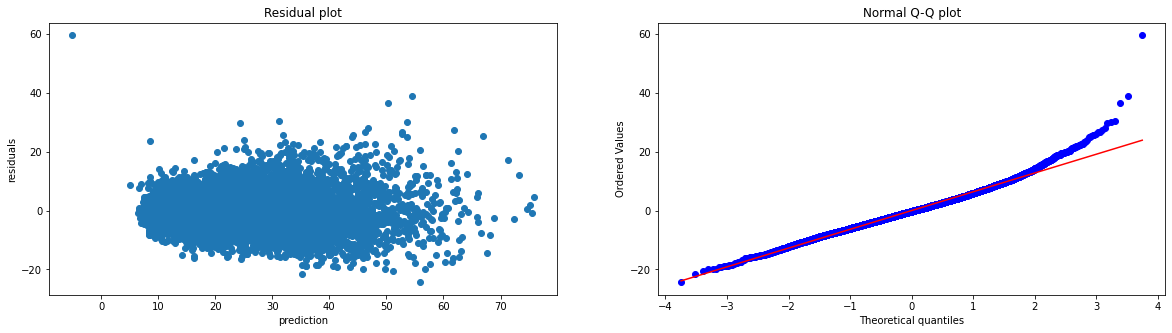

In [93]:
diagnostic_plot(X_val, y_val)

In [94]:
fds_df_t = fds_df_t.reset_index().drop('index', axis=1)

# Conclusion

In [95]:
test_df = fds_df.sample(random_state = 4543)
test_df.head()

,Date,Age,Name,Team,Opp,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,...,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
7934,2019-02-23,27,Derrick Favors,UTA,DAL,24.35,1,0,25.7,0.328542,...,265.0,8.0,99.0,109.4,110.7,1,0,0,0,0


In [96]:
test_df_f = test_df[['Age', 'Minutes Played', 'Personal Fouls', 'Rest Days', 'FGA/M', 
                   'Hot Streak', 'Prev FD Score', 'Weight', 'Exp', 'Opp_Avg_Pace', 
                   'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg', 'Games Started_Starter', 
                   'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']]

In [97]:
pf.fit(test_df_f)

PolynomialFeatures()

In [98]:
feat_array2 = pf.transform(test_df_f)
test_df_f_p = pd.DataFrame(feat_array2, columns = pf.get_feature_names(input_features= test_df_f.columns))

In [99]:
test_df_f_p.shape

(1, 171)

In [100]:
lm = LinearRegression()
lm.fit(X_train2, y_train2)

LinearRegression()

In [101]:
sqrt(lm.predict(test_df_f_p)) #must be due to the feature transformations

33.87934176799627

In [102]:
lm = LinearRegression()
lm.fit(fds_df[['Age', 'Minutes Played', 'Personal Fouls', 'Rest Days', 'FGA/M', 
                   'Hot Streak', 'Prev FD Score', 'Weight', 'Exp', 'Opp_Avg_Pace', 
                   'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg', 'Games Started_Starter', 
                   'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']], fds_df_t)

LinearRegression()

In [103]:
lm.predict(test_df_f)

array([[28.73445159]])

In [104]:
test_df_t = test_df['FD Score']
test_df_t

7934    25.7
Name: FD Score, dtype: float64

This was a really close prediction without any of the changes that I made

In [105]:
test_df2 = fds_df.sample(random_state = 7490)
test_df2.head()

,Date,Age,Name,Team,Opp,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,...,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
18639,2018-01-19,28,Markieff Morris,WAS,DET,31.55,4,0,31.8,0.44374,...,245.0,6.0,96.2,107.2,107.3,1,1,0,0,0


In [106]:
test_df_f2 = test_df2[['Age', 'Minutes Played', 'Personal Fouls', 'Rest Days', 'FGA/M', 
                   'Hot Streak', 'Prev FD Score', 'Weight', 'Exp', 'Opp_Avg_Pace', 
                   'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg', 'Games Started_Starter', 
                   'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']]

In [107]:
test_df_f2.head()

,Age,Minutes Played,Personal Fouls,Rest Days,FGA/M,Hot Streak,Prev FD Score,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
18639,28,31.55,4,0,0.44374,1,8.5,245.0,6.0,96.2,107.2,107.3,1,1,0,0,0


In [108]:
lm.predict(test_df_f2)

array([[30.8207839]])

In [109]:
test_df_t2 = test_df2['FD Score']
test_df_t2

18639    31.8
Name: FD Score, dtype: float64

In [110]:
#years_list_test = [2020]

In [111]:
#players_dict2 = acquire_player_dict(bball_ref_url,season_avg_link,years_list_test)
#save_raw(players_dict2,2020)
#df_2021 = clean_players(players_dict2,2020)
#acquire_team_stats(df_2021, bball_ref_url, 2020)
#acquire_team_rosters(df_2021,bball_ref_url, 2020)
#acquire_player_boxscore(df_2021,2020)

In [112]:
r_test_df3 = clean_features_data(2020)

In [113]:
r_test_df3 = pd.get_dummies(r_test_df3,columns=['Games Started', 'Position'],drop_first=True)

In [114]:
r_test_df3.sample(random_state=5454)

,Date,Age,Name,Team,Opp,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,...,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
17890,2020-01-06,28,Khris Middleton,MIL,SAS,29.44,1,0,26.0,0.543478,...,222.0,7.0,100.5,112.4,113.5,1,0,0,1,0


In [115]:
test_df3 = r_test_df3.sample(random_state=5454)
test_df3.head()

,Date,Age,Name,Team,Opp,Minutes Played,Personal Fouls,Rest Days,FD Score,FGA/M,...,Weight,Exp,Opp_Avg_Pace,Opp_Avg_Off_Rtg,Opp_Avg_Def_Rtg,Games Started_Starter,Position_PF,Position_PG,Position_SF,Position_SG
17890,2020-01-06,28,Khris Middleton,MIL,SAS,29.44,1,0,26.0,0.543478,...,222.0,7.0,100.5,112.4,113.5,1,0,0,1,0


In [116]:
test_df_f3 = test_df3[['Age', 'Minutes Played', 'Personal Fouls', 'Rest Days', 'FGA/M', 
                   'Hot Streak', 'Prev FD Score', 'Weight', 'Exp', 'Opp_Avg_Pace', 
                   'Opp_Avg_Off_Rtg', 'Opp_Avg_Def_Rtg', 'Games Started_Starter', 
                   'Position_PF', 'Position_PG', 'Position_SF', 'Position_SG']]

In [117]:
lm.predict(test_df_f3)

array([[31.1561354]])

In [119]:
lm.predict(test_df_f3)

array([[31.1561354]])

In [118]:
test_df_t3 = test_df3['FD Score']
test_df_t3

17890    26.0
Name: FD Score, dtype: float64